# EVALUATION: Reading Metrics


## Import libraries

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from utils.utils import *

In [2]:
# get all files from participants
folders = get_participant_folder_per_participant(raw_folder=False)
print(folders)
aoi_data = pd.read_csv(AOI_SIZE_PATH, sep=SEPARATOR, index_col=0)
display(aoi_data)

in subfolder ../08-Data-Trial_Recordings/processed/total, no participant number could be identified.
{'003': WindowsPath('../08-Data-Trial_Recordings/processed/003'), '004': WindowsPath('../08-Data-Trial_Recordings/processed/004'), '005': WindowsPath('../08-Data-Trial_Recordings/processed/005'), '007': WindowsPath('../08-Data-Trial_Recordings/processed/007'), '008': WindowsPath('../08-Data-Trial_Recordings/processed/008'), '009': WindowsPath('../08-Data-Trial_Recordings/processed/009'), '010': WindowsPath('../08-Data-Trial_Recordings/processed/010'), '011': WindowsPath('../08-Data-Trial_Recordings/processed/011'), '012': WindowsPath('../08-Data-Trial_Recordings/processed/012'), '013': WindowsPath('../08-Data-Trial_Recordings/processed/013'), '014': WindowsPath('../08-Data-Trial_Recordings/processed/014'), '015': WindowsPath('../08-Data-Trial_Recordings/processed/015'), '016': WindowsPath('../08-Data-Trial_Recordings/processed/016'), '017': WindowsPath('../08-Data-Trial_Recordings/proce

,NO,Snippet,Snippet_base,number,version,AoI_size,OPTIMAL,bottom,left,right,top
Condition,,,,,,,,,,,
unambiguous,NEXP,-clean-v0,--v0,0,v0,1836,True,413,743,794,377
unambiguous,STAT,-clean-v0,--v0,0,v0,22578,False,422,555,981,369
unambiguous,WEXP,-clean-v0,--v0,0,v0,10428,False,417,739,976,373
ambiguous,NEXP,-obf-v0,--v0,0,v0,2304,True,413,781,845,377
ambiguous,STAT,-obf-v0,--v0,0,v0,27348,False,422,555,1071,369
...,...,...,...,...,...,...,...,...,...,...,...
unambiguous,OP,9-clean-v2,9--v2,9,v2,496,False,407,581,612,391
unambiguous,WEXP,9-clean-v2,9--v2,9,v2,7084,False,364,739,900,320
ambiguous,NEXP,9-obf-v2,9--v2,9,v2,1920,True,357,756,820,327


In [ ]:
algorithms = [True, FIXATION_SELECTION_ALGORITHM_FIRST_AOI_PADDING_SMALL]
metrics = ['total_reading_time_snippet', 'total_reading_time_aoi', 'first_pass_aoi', 'number_fixations_aoi', 'number_visits_aoi']
results = {
    algorithm: pd.DataFrame(
        columns=[PARTICIPANT, SNIPPET, *metrics]
    ) for algorithm in algorithms
}

for participant in tqdm(folders):
    print('----------------------------------------------')
    print(PARTICIPANT, participant)
    # skip participant if excluded
    exclusions = get_exclusions(participant, [PARTICIPANT])[PARTICIPANT]
    if any(exclusions.values()):
        print('excluded')
        continue
    for algorithm in algorithms:
        if algorithm==True:
            erp_status = {s:("Excluded" if any(exc.values()) else "Included") for s, exc in get_exclusions(participant, [SNIPPET])[SNIPPET].items()}
        else:
            erp_status_path = get_erp_status_path(algorithm, SNIPPET_GROUP_ALL, get_erp_description(algorithm, False, (-0.3, 1.0)), participant)
            with open(erp_status_path, 'r') as f:
                erp_status = json.load(f)
        for snippet in erp_status:
            if erp_status[snippet]!="Included":
                print(f'\t{snippet} was excluded due to {erp_status[snippet]}')
                continue
            aois = aoi_data[aoi_data[SNIPPET] == snippet]
            optimal_aoi = aois[aois[OPTIMAL]]
            snippet_fixations_path = get_selected_fixations_path(participant, snippet)
            fixation_data = pd.read_csv(
                snippet_fixations_path, index_col=False, sep=SEPARATOR, dtype={PARTICIPANT: str})
            aoi_fixation_data = get_fixations_in_aoi(fixation_data, aois, AOI_PADDING_SMALL)
            fixation_data['AOI'] = fixation_data.index.map(lambda id: id in aoi_fixation_data.index)
            fixation_data['visit_counter'] = (1-fixation_data['AOI']*1).cumsum()
            fixation_data['visit_counter'] = fixation_data['visit_counter'].mask(~fixation_data['AOI'], other=0)
            visit_indices = fixation_data[fixation_data['AOI']]['visit_counter'].drop_duplicates(keep='first').reset_index(drop=True).to_dict()
            visit_indices = {v: k+1 for k, v in visit_indices.items()}
            assert(not len(visit_indices) or (len(visit_indices) == max(visit_indices.values())))
            # TODO: special fixation benutzen
            fixation_data['visit_counter'] = fixation_data.apply(lambda x: visit_indices[x['visit_counter']] if x['AOI'] else 0, axis=1)
            # metric 1 total reading time snippet (sum of all fixation durations)
            total_reading_time_snippet = fixation_data[FIXATION_COLUMN_DURATION].sum()
            # metric 2 total reading time optimal aoi (sum of all fixation durations in optimal aoi)
            total_reading_time_aoi = aoi_fixation_data[FIXATION_COLUMN_DURATION].sum()
            # metric 3 duration first pass optimal aoi (sum of all fixations beginning from special fixation to leaving the aoi for the first time)
            first_pass_aoi = fixation_data[fixation_data['visit_counter']==1][FIXATION_COLUMN_DURATION].sum()
            # metric 4 number of fixations in optimal aoi
            number_fixations_aoi = aoi_fixation_data.shape[0]
            # metric 5 number of visiting optimal aoi (1 visited once, 2 visited, left and visited again)
            number_visits_aoi = len(visit_indices)
            # metric 6 go-past time (sum of all fixation durations until leaving the aoi for the  first time to either right or lower)
            # TODO
            
            results[algorithm].loc[len(results[algorithm])] = [participant, snippet, total_reading_time_snippet, total_reading_time_aoi, first_pass_aoi, number_fixations_aoi, number_visits_aoi] 

for algorithm in results:
    results[algorithm].to_csv(get_erp_fixation_analysis_path(algorithm, SNIPPET_GROUP_ALL, 'all', 'reading metrics'), sep=SEPARATOR, index=False)
    display(results[algorithm])


  0%|          | 0/24 [00:00<?, ?it/s]

----------------------------------------------
Participant 003
	-clean-v1 was excluded due to Excluded
	-clean-v2 was excluded due to Excluded
	10-obf-v2 was excluded due to Excluded
	12-clean-v1 was excluded due to Excluded
	12-clean-v2 was excluded due to Excluded
	13-clean-v2 was excluded due to Excluded
	16-obf-v0 was excluded due to Excluded
	17-obf-v2 was excluded due to Excluded
	4-obf-v2 was excluded due to Excluded
	49-obf-v1 was excluded due to Excluded
	54-obf-v0 was excluded due to Excluded
	54-obf-v1 was excluded due to Excluded
	57-clean-v0 was excluded due to Excluded
	60-clean-v0 was excluded due to Excluded
	60-clean-v1 was excluded due to Excluded
	63-obf-v0 was excluded due to Excluded
	63-obf-v2 was excluded due to Excluded
	7-clean-v2 was excluded due to Excluded
	9-clean-v2 was excluded due to Excluded
	12-clean-v0 was excluded due to No stimulus found, fixation data of this trials likely did not contain any fixation fulfilling the requirements for this FRP calcul

,Participant,Snippet,total_reading_time_snippet,total_reading_time_aoi,first_pass_aoi,number_fixations_aoi,number_visits_aoi
0,003,-clean-v0,9.955393,2.601564,0.290816,5,5
1,003,10-obf-v0,13.225277,10.129551,3.579827,7,3
2,003,10-obf-v1,6.064087,2.155049,0.300928,4,4
3,003,11-obf-v0,4.058192,2.304095,0.719979,3,2
4,003,11-obf-v1,4.064852,3.710688,0.868316,5,2
...,...,...,...,...,...,...,...
1495,106,7-clean-v0,9.776206,2.436565,1.532436,3,3
1496,106,7-clean-v1,11.441558,2.415726,0.742453,6,5
1497,106,8-obf-v0,11.652681,4.357403,0.351646,10,7
1498,106,8-obf-v2,11.240359,2.772411,1.125800,4,4


,Participant,Snippet,total_reading_time_snippet,total_reading_time_aoi,first_pass_aoi,number_fixations_aoi,number_visits_aoi
0,003,-clean-v0,9.955393,2.601564,0.290816,5,5
1,003,10-obf-v0,13.225277,10.129551,3.579827,7,3
2,003,10-obf-v1,6.064087,2.155049,0.300928,4,4
3,003,11-obf-v0,4.058192,2.304095,0.719979,3,2
4,003,11-obf-v1,4.064852,3.710688,0.868316,5,2
...,...,...,...,...,...,...,...
1382,106,63-clean-v2,14.411309,1.277451,0.749141,3,2
1383,106,7-clean-v1,11.441558,2.415726,0.742453,6,5
1384,106,8-obf-v0,11.652681,4.357403,0.351646,10,7
1385,106,8-obf-v2,11.240359,2.772411,1.125800,4,4


,Participant,Snippet,total_reading_time_snippet,total_reading_time_aoi,first_pass_aoi,number_fixations_aoi,number_visits_aoi
0,003,-clean-v0,9.955393,2.601564,0.290816,5,5
1,003,10-obf-v0,13.225277,10.129551,3.579827,7,3
2,003,10-obf-v1,6.064087,2.155049,0.300928,4,4
3,003,11-obf-v0,4.058192,2.304095,0.719979,3,2
4,003,11-obf-v1,4.064852,3.710688,0.868316,5,2
...,...,...,...,...,...,...,...
1380,106,63-clean-v2,14.411309,1.277451,0.749141,3,2
1381,106,7-clean-v1,11.441558,2.415726,0.742453,6,5
1382,106,8-obf-v0,11.652681,4.357403,0.351646,10,7
1383,106,8-obf-v2,11.240359,2.772411,1.125800,4,4


In [12]:
for algorithm in results:
    results[algorithm][CONDITION] = results[algorithm][SNIPPET].map(lambda snippet: CONDITION_VARIANT_MATCH[get_snippet_variant(snippet)])
    stats = results[algorithm].groupby([CONDITION])[metrics].agg(PANDAS_DESCRIPTION_AGG_FUNCTIONS)
    stats.columns = pd.MultiIndex.from_product([metrics, PANDAS_DESCRIPTION_AGG_NAMES], names=['Metric', 'Statistic'])
    stats.to_csv(get_erp_fixation_analysis_path(algorithm, SNIPPET_GROUP_ALL, 'all', 'reading metrics stats'), sep=SEPARATOR)
    display(stats)

Metric      total_reading_time_snippet                                 
Statistic                        count      mean       std       min   
Condition                                                              
ambiguous                          743  9.498736  6.654228  1.698284  \
unambiguous                        757  8.678278  6.103357  0.722448   

Metric                                               total_reading_time_aoi   
Statistic         25%   median        75%        max                  count   
Condition                                                                     
ambiguous    4.648408  7.12821  12.172524  28.518223                    743  \
unambiguous  4.284828  6.82339  10.479799  28.981631                    757   

Metric                ... number_fixations_aoi     number_visits_aoi   
Statistic       mean  ...                  75% max             count   
Condition             ...                                              
ambiguous    2.61962  ...                  6.0  24               743  \
unambiguous  1.77958  ...                  4.0  27               757   

Metric                                                    
Statistic        mean       std min  25% median  75% max  
Condition                                                 
ambiguous    3.227456  2.381012   0  2.0    3.0  4.0  17  
unambiguous  2.718626  2.218569   0  1.0    2.0  3.0  15  

[2 rows x 40 columns]

Metric      total_reading_time_snippet                                 
Statistic                        count      mean       std       min   
Condition                                                              
ambiguous                          700  9.624905  6.707699  1.698284  \
unambiguous                        687  8.983344  6.230035  0.722448   

Metric                                                total_reading_time_aoi   
Statistic         25%    median        75%        max                  count   
Condition                                                                      
ambiguous    4.725556  7.279017  12.252157  28.518223                    700  \
unambiguous  4.578648  7.028172  10.896309  28.981631                    687   

Metric                 ... number_fixations_aoi     number_visits_aoi   
Statistic        mean  ...                  75% max             count   
Condition              ...                                              
ambiguous    2.733849  ...                  6.0  24               700  \
unambiguous  1.936278  ...                  4.0  27               687   

Metric                                                    
Statistic        mean       std min  25% median  75% max  
Condition                                                 
ambiguous    3.358571  2.352668   1  2.0    3.0  4.0  17  
unambiguous  2.940320  2.196125   1  1.0    2.0  4.0  15  

[2 rows x 40 columns]

Metric      total_reading_time_snippet                                 
Statistic                        count      mean       std       min   
Condition                                                              
ambiguous                          699  9.612951  6.705037  1.698284  \
unambiguous                        686  8.978836  6.233460  0.722448   

Metric                                                total_reading_time_aoi   
Statistic         25%    median        75%        max                  count   
Condition                                                                      
ambiguous    4.723101  7.278144  12.214543  28.518223                    699  \
unambiguous  4.576391  7.027654  10.869910  28.981631                    686   

Metric                 ... number_fixations_aoi     number_visits_aoi   
Statistic        mean  ...                  75% max             count   
Condition              ...                                              
ambiguous    2.732504  ...                  6.0  24               699  \
unambiguous  1.936902  ...                  4.0  27               686   

Metric                                                    
Statistic        mean       std min  25% median  75% max  
Condition                                                 
ambiguous    3.359084  2.354314   1  2.0    3.0  4.0  17  
unambiguous  2.943149  2.196475   1  1.0    2.0  4.0  15  

[2 rows x 40 columns]

{}
	total_reading_time_snippet diff_ambiguous-unambiguous might be normally distributed due to 0.636 greater equals to alpha 0.05; Result ShapiroResult(statistic=0.9687525629997253, pvalue=0.6362825036048889)
	For total_reading_time_snippet, the t-test paired's stance on the H1 `confusing greater than clean` indicates with alpha=0.05 and the p-value of 0.007: H1 accepted; Result TtestResult(statistic=2.6418123728518563, pvalue=0.007287673975513888, df=23)
		Effect size 0.25206624936478345 small
	total_reading_time_aoi diff_ambiguous-unambiguous might be normally distributed due to 0.15 greater equals to alpha 0.05; Result ShapiroResult(statistic=0.9383494257926941, pvalue=0.14986033737659454)
	For total_reading_time_aoi, the t-test paired's stance on the H1 `confusing greater than clean` indicates with alpha=0.05 and the p-value of 0.0: H1 accepted; Result TtestResult(statistic=5.376017088687812, pvalue=9.221812272989994e-06, df=23)
		Effect size 0.8034103679742503 large
	first_pass_ao

<Figure size 640x480 with 0 Axes>

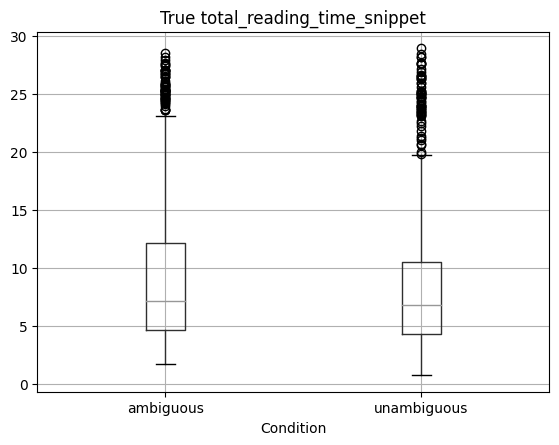

<Figure size 640x480 with 0 Axes>

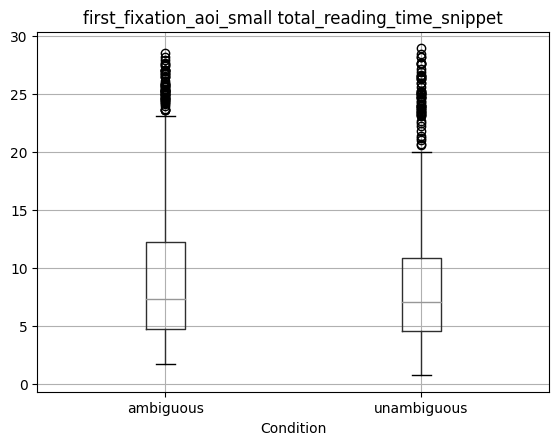

<Figure size 640x480 with 0 Axes>

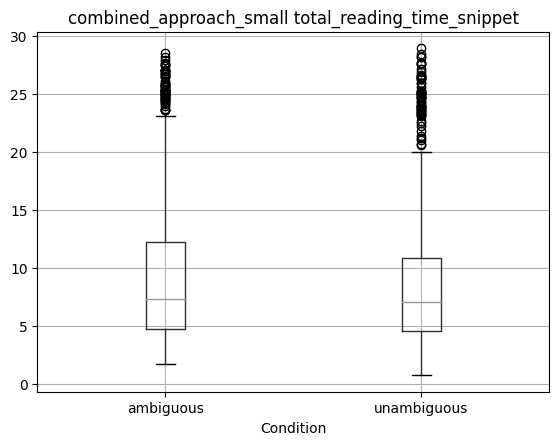

<Figure size 640x480 with 0 Axes>

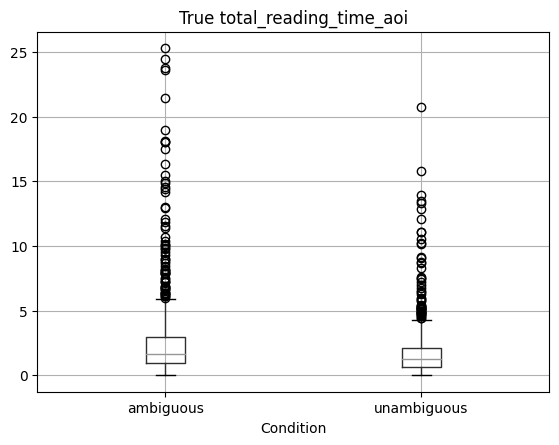

<Figure size 640x480 with 0 Axes>

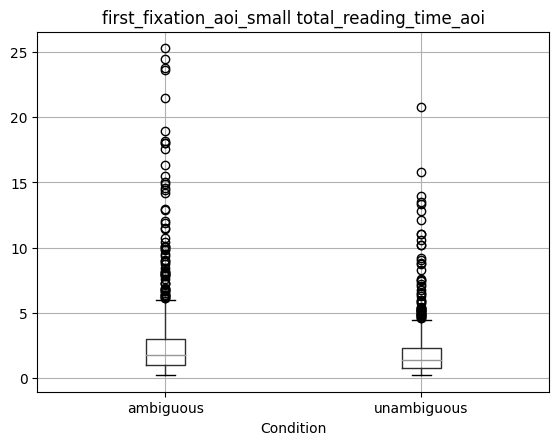

<Figure size 640x480 with 0 Axes>

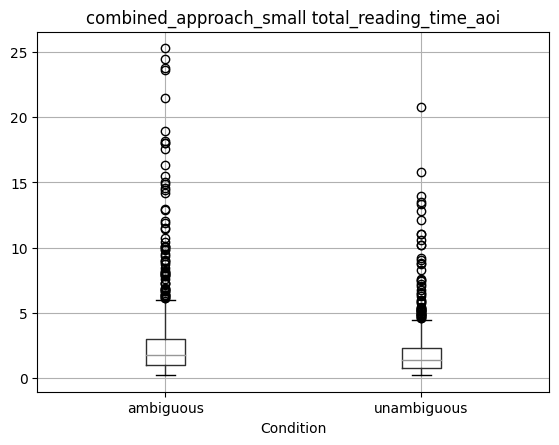

<Figure size 640x480 with 0 Axes>

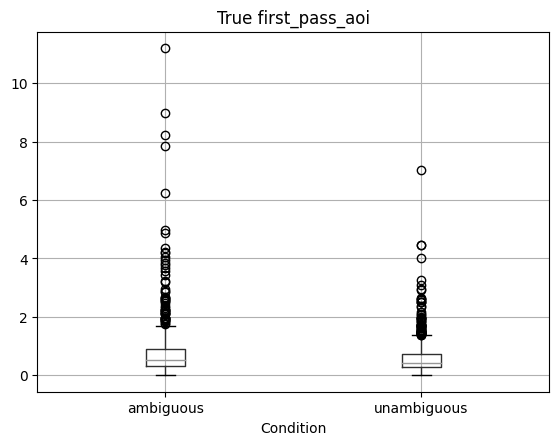

<Figure size 640x480 with 0 Axes>

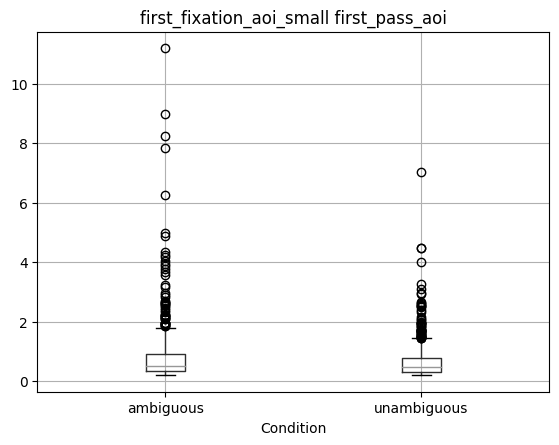

<Figure size 640x480 with 0 Axes>

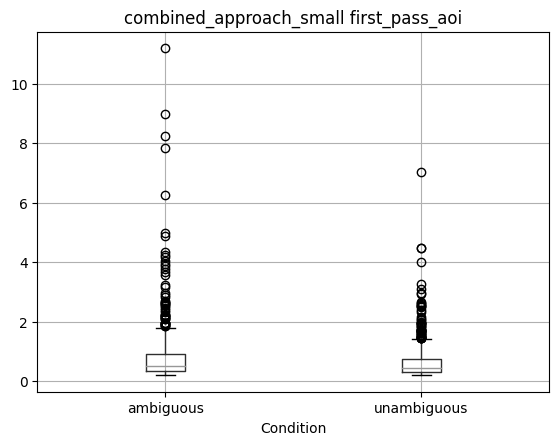

<Figure size 640x480 with 0 Axes>

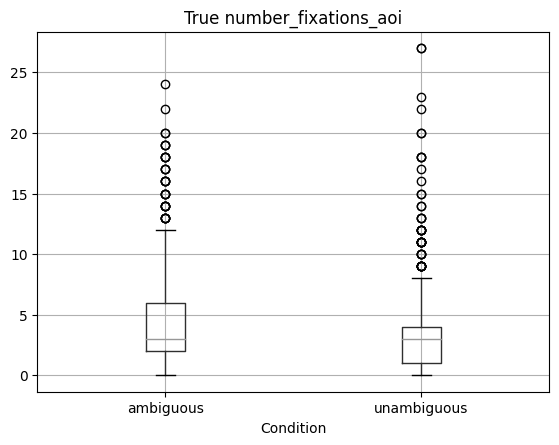

<Figure size 640x480 with 0 Axes>

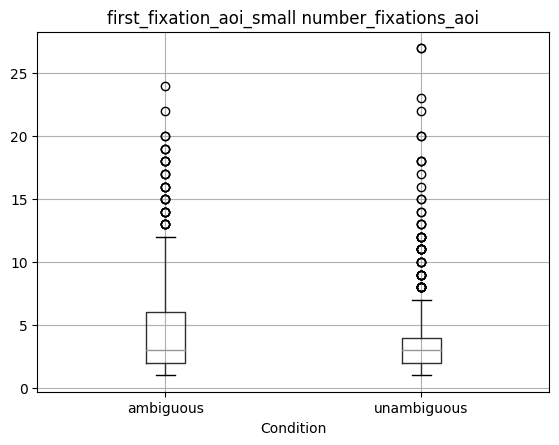

<Figure size 640x480 with 0 Axes>

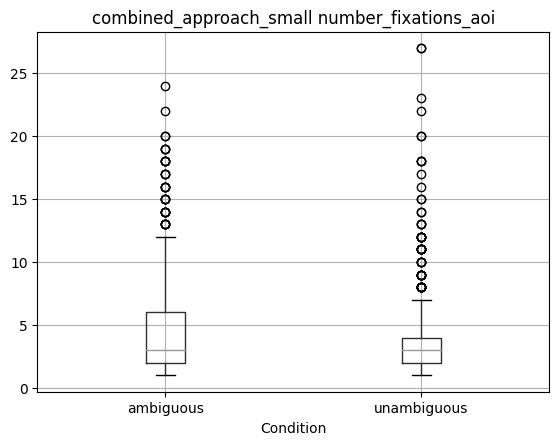

<Figure size 640x480 with 0 Axes>

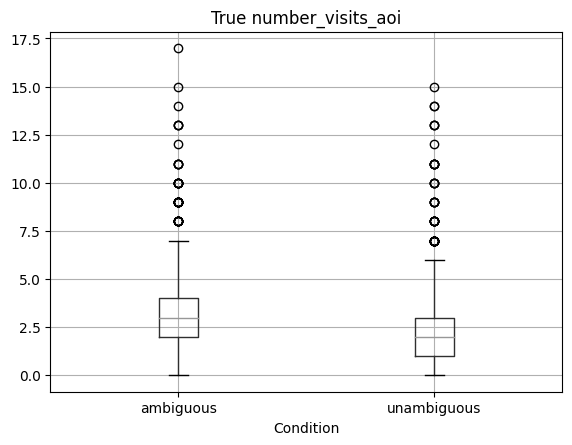

<Figure size 640x480 with 0 Axes>

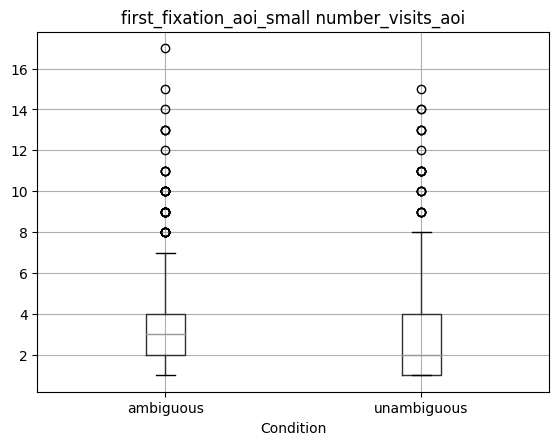

<Figure size 640x480 with 0 Axes>

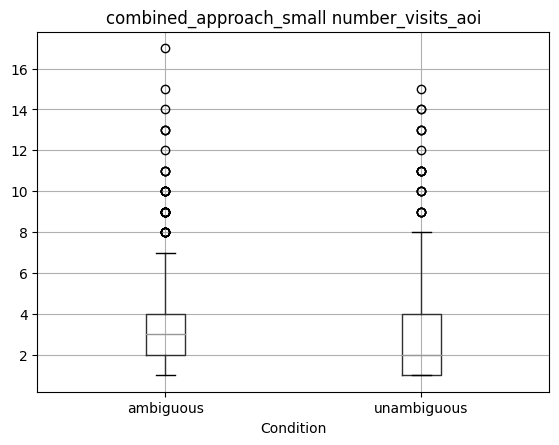

In [6]:
alternative_hypotheses = {metric: ALTERNATIVE_HYPOTHESIS_GREATER for metric in metrics}
for algorithm in results:
  statistical_analysis_for_subjectwise_averages(results[algorithm], alternative_hypotheses,  [], stest_kind=TEST_KIND_PAIRED)

for metric in metrics:
    for algorithm in results:
        plt.figure()
        results[algorithm].boxplot(column=metric, by=CONDITION)
        plt.title(f'{algorithm} {metric}')
        plt.suptitle('')
        plt.show()